# Counter-AI

## Objective
The objective of this project is to build a classifier that can identify if an answer to a StackOverflow question was generated by a human or GPT language model.

## Data
The data for this project was fetched from StackExchange and OpenAI public APIs

# Data Preparation and Analysis

In [1]:
import pandas as pd
import numpy as np
from util.preprocess_util import label, remove_duplicates, tokenize, strip_whites

[nltk_data] Downloading package punkt to /home/iliav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data = pd.read_json("data/data.jsonl", lines=True)
data

,question_id,question,human_answer,ai_answer
0,927358,How do I undo the most recent local commits in...,"Undo a commit & redo\n$ git commit -m ""Somethi...",\nThe easiest way to undo the most recent loca...
1,2003505,How do I delete a Git branch locally and remot...,Executive Summary\ngit push -d <remote_name> <...,\n1. Delete the local branch:\ngit branch -d <...
2,292357,What is the difference between 'git pull' and ...,"In the simplest terms, git pull does a git fet...",\nGit pull is a combination of git fetch and g...
3,477816,Which JSON content type do I use?\n\nThere are...,For JSON text:\napplication/json\n\n\nThe MIME...,\nThe most widely used and supported JSON cont...
4,5767325,How can I remove a specific item from an array...,Find the index of the array element you want t...,\nYou can use the Array.prototype.filter() met...
...,...,...,...,...
8633,5143769,How do I check if a given Python string is a s...,Try using in like this:\n\n>>> x = 'hello'\n>>...,"\nYes, Python has a built-in method called the..."
8634,5878697,How do I remove blank elements from an array?\...,"There are many ways to do this, one is reject\...","\nYes, you can use the Array.filter() method t..."
8635,7054972,Java system properties and environment variabl...,I think the difference between the two boils d...,\nSystem properties (System.getProperties()) a...
8636,7785374,How to prevent column break within an element?...,The correct way to do this is with the break-i...,\nTo prevent the column break within an elemen...


## Removing duplicates

In [3]:
data.duplicated(subset='question_id').sum()

30

In [4]:
remove_duplicates(data)

## Labeling
Here I'm splitting the dataset into two equal parts (with odd and even numbers), one of which will be labeled with 1 and contain the answer from AI and the other - with 0 and answer from Stackoverflow

In [5]:
label(data)
data

,question_id,question,target,answer
0,927358,How do I undo the most recent local commits in...,0,"Undo a commit & redo\n$ git commit -m ""Somethi..."
1,2003505,How do I delete a Git branch locally and remot...,1,\n1. Delete the local branch:\ngit branch -d <...
2,292357,What is the difference between 'git pull' and ...,0,"In the simplest terms, git pull does a git fet..."
3,477816,Which JSON content type do I use?\n\nThere are...,1,\nThe most widely used and supported JSON cont...
4,5767325,How can I remove a specific item from an array...,0,Find the index of the array element you want t...
...,...,...,...,...
8633,5143769,How do I check if a given Python string is a s...,1,"\nYes, Python has a built-in method called the..."
8634,5878697,How do I remove blank elements from an array?\...,0,"There are many ways to do this, one is reject\..."
8635,7054972,Java system properties and environment variabl...,1,\nSystem properties (System.getProperties()) a...
8636,7785374,How to prevent column break within an element?...,0,The correct way to do this is with the break-i...


Let's double-check we don't have question duplicates:

In [6]:
labeled_data = data
labeled_data.duplicated(subset='question_id').sum()

0

In [7]:
labeled_data = pd.read_json("./data/balanced_data.jsonl", lines=True)
labeled_data

,question_id,answer,target,question
0,11227809,An answer for quick and simple understanding (...,0,Why is processing a sorted array faster than p...
1,292357,Fetch\ngit fetch really only downloads new dat...,0,How do I undo the most recent local commits in...
2,477816,The most common MIME type is application/json....,0,How do I delete a Git branch locally and remot...
3,5767325,"let removeAnElement = (arr, element)=>{\n l...",0,What is the difference between 'git pull' and ...
4,244777,"I searched all pages of answers, and none ment...",0,"What does the ""yield"" keyword do?\n\nCan I use..."
...,...,...,...,...
2889,1213430,To delete a Git repository that was created wi...,1,How to change indentation in Visual Studio Cod...
2890,4470523,You are not doing anything wrong. The fast-for...,1,How to specify a port to run a create-react-ap...
2891,15202997,The difference between the three is:\r\n\r\nSi...,1,What's the PostgreSQL datatype equivalent to M...
2892,4912092,Google uses JavaScript to capture screenshots ...,1,"Does Python have an ordered set?\n\nGoogle's ""..."


## Cleanup

We see, that ai answers tend to start with newline, so let's strip whitespaces from both the whole `answer` column

In [8]:
strip_whites(labeled_data)
labeled_data[:4]

,question_id,answer,target,question
0,11227809,An answer for quick and simple understanding (...,0,Why is processing a sorted array faster than p...
1,292357,Fetch\ngit fetch really only downloads new dat...,0,How do I undo the most recent local commits in...
2,477816,The most common MIME type is application/json....,0,How do I delete a Git branch locally and remot...
3,5767325,"let removeAnElement = (arr, element)=>{\n l...",0,What is the difference between 'git pull' and ...


## Tokenizing questions and answers
To handle the text data it's convenient to tokenize it, i.e. split into separate words (tokens). We'll also immediately stem the tokens, so that different forms of the same word become a single token

In [9]:
tokenize(labeled_data)
labeled_data[['tokenized_answer', 'tokenized_question']]

,tokenized_answer,tokenized_question
0,"[an, answer, for, quick, and, simpl, understan...","[whi, is, process, a, sort, array, faster, tha..."
1,"[fetch, git, fetch, realli, onli, download, ne...","[how, do, i, undo, the, most, recent, local, c..."
2,"[the, most, common, mime, type, is, applicatio...","[how, do, i, delet, a, git, branch, local, and..."
3,"[let, removeanel, =, (arr,, element)=>{, let, ...","[what, is, the, differ, between, git, pull, an..."
4,"[i, search, all, page, of, answers,, and, none...","[what, doe, the, ""yield"", keyword, do?, can, i..."
...,...,...
2889,"[to, delet, a, git, repositori, that, was, cre...","[how, to, chang, indent, in, visual, studio, c..."
2890,"[you, are, not, do, anyth, wrong., the, fast-f...","[how, to, specifi, a, port, to, run, a, create..."
2891,"[the, differ, between, the, three, is:, simpl,...","[what, the, postgresql, datatyp, equival, to, ..."
2892,"[googl, use, javascript, to, captur, screensho...","[doe, python, have, an, order, set?, googl, ""r..."


Later we'll need also stemmed answer as a string

In [10]:
labeled_data['stemmed_answer']

0       an answer for quick and simpl understand (read...
1       fetch git fetch realli onli download new data ...
2       the most common mime type is application/json....
3       let removeanel = (arr, element)=>{ let findind...
4       i search all page of answers, and none mention...
                              ...                        
2889    to delet a git repositori that was creat with ...
2890    you are not do anyth wrong. the fast-forward m...
2891    the differ between the three is: simpl name: g...
2892    googl use javascript to captur screenshot in t...
2893    the issu is that the server you are tri to fet...
Name: stemmed_answer, Length: 2894, dtype: object

## Feature Engineering
I have several hypotheses about the behaviour of GPT:
1. It tends to repeat parts of the question in its answer
2. Its own vocabulary is smaller and less variate comparing to average human's
3. The size of the answers is less variate than that of humans'

Keeping these in mind I'll create several numerical features and later try to train a regression model on them.

### Helpers

In [11]:
from util.preprocess_util import add_stealing, add_vocabulary, add_creativity, add_answer_length, add_sentence_length

In [12]:
from util.plot_util import comparation_hist

### Feature: Creativity
I'm introducing the term creativity to describe how many original words are used in the answer. Hence the feature:
* `creativity` - number of all unique words in the answer that are not present in the question, divided by the size of the answer

In [13]:
add_creativity(labeled_data)

In [14]:
labeled_data.creativity.mean()

0.5107463936441272

In [15]:
labeled_data[labeled_data.target==0].creativity.mean(), labeled_data[labeled_data.target==1].creativity.mean()


(0.5814716015368749, 0.4400211857513793)

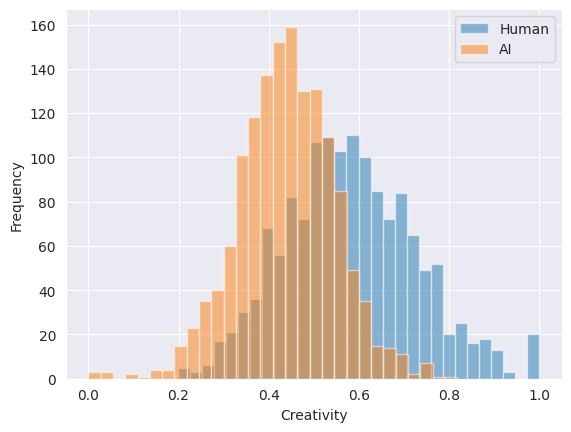

In [16]:
comparation_hist(labeled_data, 'creativity', 'Creativity')

There is obviously a difference in creativity between humans and AI

### Feature: Vocabulary Size
Assuming that number of unique words may be different in human and AI answers, I'm introducing two more features:
* `n_unique_words` - number of unique words in the answer
* `vocabulary_size` - `unique_words` divided by the size of the tokenized answer

In [17]:
add_vocabulary(labeled_data)

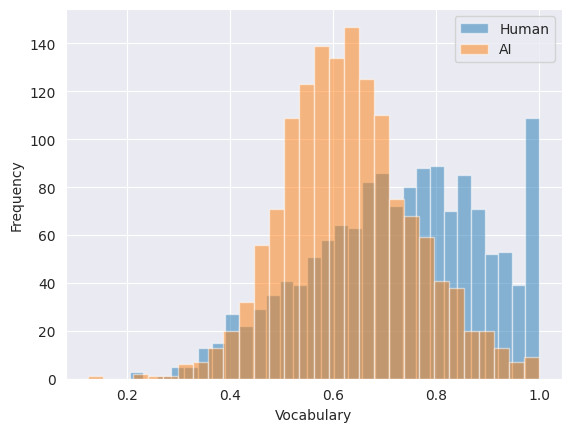

In [18]:
comparation_hist(labeled_data, 'vocabulary_size', 'Vocabulary')

This metric doesn't seem to be of any value

### Feature: Stealing
Opposite to creativity, stealing shows how many words sequences were 'stolen' from the question and taken into the answer. I'm breaking questions and answers into n-grams (word sequences of length n) and then find the common ngrams. Then I create two features:

* `stealing_strength` - maximum length (number of words) of a stolen ngram
* `stealing_frequency` - total number of stolen ngrams divided by number of unique words

In [19]:
%%time
add_stealing(labeled_data)

CPU times: user 4.02 s, sys: 1.65 ms, total: 4.02 s
Wall time: 4.02 s


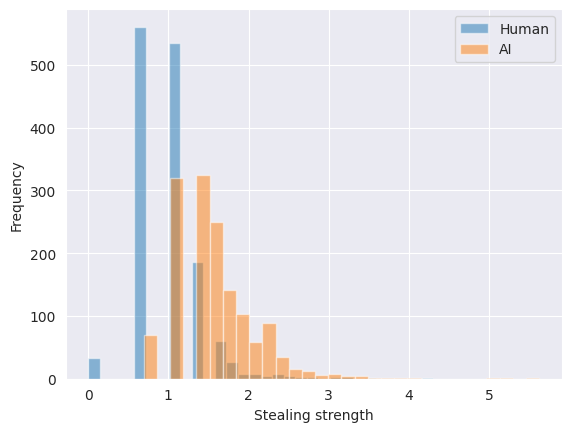

In [20]:
comparation_hist(labeled_data, 'stealing_strength', 'Stealing strength')

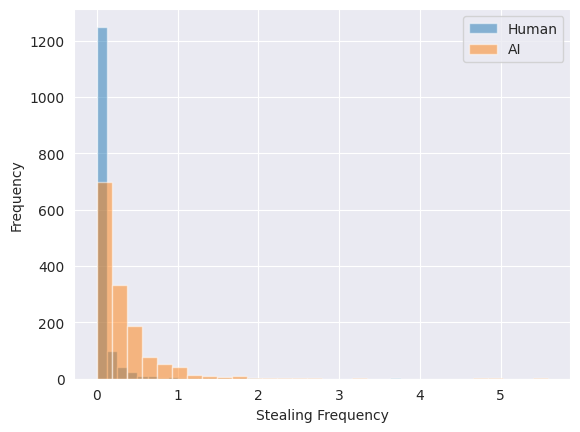

In [21]:
comparation_hist(labeled_data, 'stealing_frequency', 'Stealing Frequency')

### Feature: Answer Length
Even though I've limited maximum answer length of human- and ai- generated answers, the distribution might still be different. So another feature:
* `answer_length`

In [22]:
add_answer_length(labeled_data)

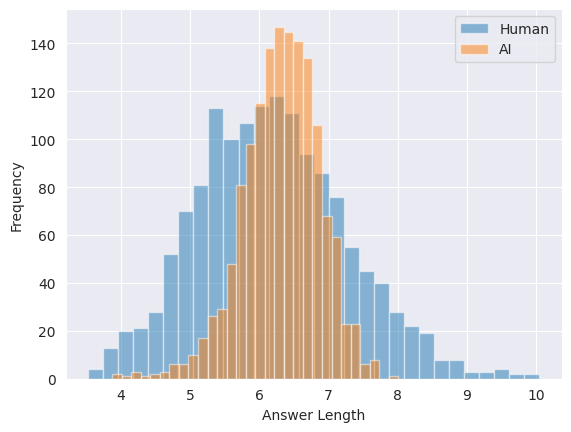

In [23]:
comparation_hist(labeled_data, 'answer_length', 'Answer Length')

### Feature: Sentence length
Here I'm adding two more metrics related to sentence length in answer calculated as number of tokens.
* `sentence_length_mean` - mean length of sentences (log1p applied)
* `sentence_length_std` - standard deviation length of sentences (log1p applied)

In [24]:
add_sentence_length(labeled_data)

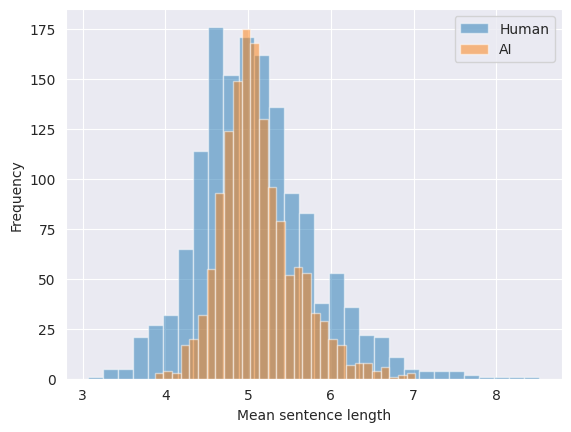

In [25]:
comparation_hist(labeled_data, 'sentence_length_mean', 'Mean sentence length')

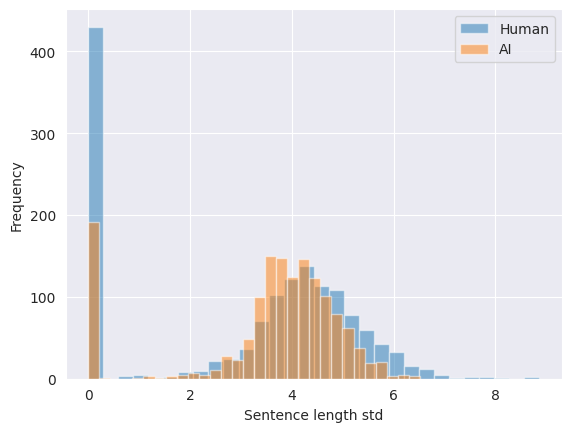

In [26]:
comparation_hist(labeled_data, 'sentence_length_std', 'Sentence length std')

### Features correlation

In [27]:
labeled_data = labeled_data.fillna(0)
new_features = ['answer_length', 'creativity', 'stealing_frequency', 'stealing_strength', 'sentence_length_std', 'sentence_length_mean', 'vocabulary_size']

<AxesSubplot: >

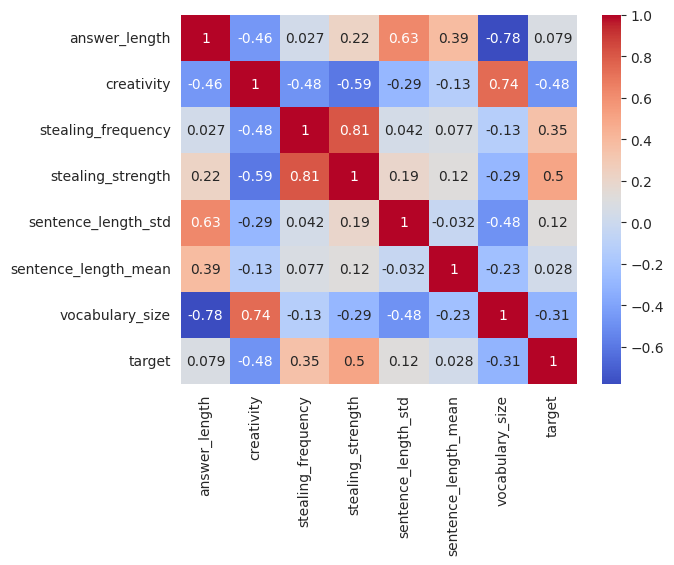

In [28]:
import seaborn as sns

sns.heatmap(labeled_data[new_features + ['target']].corr(), annot=True, cmap='coolwarm')

From this heatmap the following observations can be made:
* All features except `vocabulary_size` show significant correlation with target
* The following pairs show high correlation with each other:
    * `vocabulaty_size` and `creativity`
    * `stealing_frequency` and `creativity` (negative correlation)
    * `stealing_strength` and `creativity` (negative correlation)
    * `stealing_strength` and `stealing_frequency`
    * `answer_length` and `sentence_length_mean`
    * `answer_length` and `sentence_length_std`
* What's interesting is that despite the last two correlations `sentence_length_std` and `sentence_length_mean` do not correlate much
* However, the correlations do not seem to be too high, so it makes sense to try all the features

## Saving preprocessed data
Some steps like calculating stolen ngrams take too long to perform them with every training script, so I'm saving this preprocessed data for future usage in production model training

In [29]:
labeled_data.to_json("data/preprocessed.jsonl", lines=True, orient="records")

# Training models
I'm going to train several models and compare the results:
1. Logistic regression on the new features and select the best
2. Naive Bayes on vectorized answers
3. Combination of the previous two in two-layered pipeline

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import CountVectorizer
from util.train_util import grid_search
from util.plot_util import plot_grid_results

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

## Data split

In [31]:
df_full_train, df_test = train_test_split(labeled_data, test_size=0.2, random_state=30)

## Logistic regression

In [32]:
lr = LogisticRegression(max_iter=500, class_weight="balanced")
features = []
scores = []
for f in new_features:
    features.append(f)
    score = cross_val_score(lr, df_full_train[features], df_full_train.target, scoring='f1').mean()
    scores.append(score)
pd.DataFrame(list(zip(features, np.round(scores, 3))))

,0,1
0,answer_length,0.559
1,creativity,0.727
2,stealing_frequency,0.737
3,stealing_strength,0.770
4,sentence_length_std,0.774
5,sentence_length_mean,0.771
6,vocabulary_size,0.786


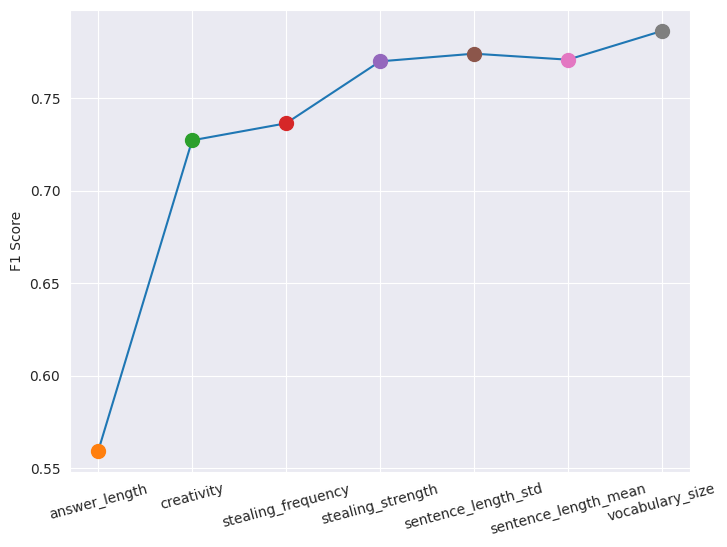

In [33]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))

sns.lineplot(x=new_features, y=scores)
plt.xticks(rotation=15)
for i in range(len(new_features)):
    plt.plot(new_features[i], scores[i], 'o', markersize=10)
plt.ylabel('F1 Score')
plt.savefig("features_input.png")

Conclusions:
* `stealing_frequency` and `sentence_length_std` do not add much to the performance and can be dropped
* surprisingly `vocabulary_size` does add some score points, despite it's low correlation with `target` and unconvincing histogram chart

In [69]:
selected_features = [f for f in new_features if f not in ['sentence_length_mean']]
selected_features

['answer_length',
 'creativity',
 'stealing_frequency',
 'stealing_strength',
 'sentence_length_std',
 'vocabulary_size']

In [70]:
lr_tuning_grid = {
    'C': np.logspace(-3,2,6),
    'solver': ['lbfgs', 'liblinear', 'sag']
}
grid_search_results = grid_search(lr, lr_tuning_grid, df_full_train[selected_features], df_full_train.target)

Tuned Hyperparameters: {'C': 10.0, 'solver': 'sag'}
F1 score : 0.7924570099076715


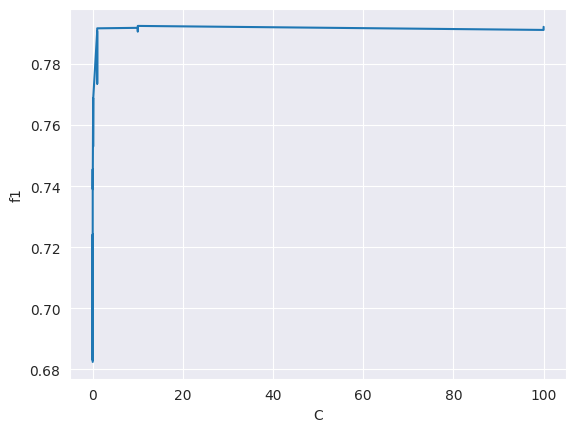

In [71]:
plot_grid_results(grid_search_results, x_var='C')

### Score on Test Data

In [130]:
lr = LogisticRegression(C=10.0, solver='sag', class_weight="balanced")
lr.fit(df_full_train[selected_features], df_full_train.target)
lr_score = round(f1_score(lr.predict(df_test[selected_features]), df_test.target), 3)
lr_score

/home/iliav/Documents/workspaces/counter-ai/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.805

## XGBoost

In [73]:
from xgboost.sklearn import XGBClassifier

scale_pos_weight = df_full_train.target.value_counts()[0] / df_full_train.target.value_counts()[1]

xgb = XGBClassifier(learning_rate = 0.3, n_estimators = 20, scale_pos_weight=scale_pos_weight)

all_features = ['creativity', 'stealing_strength', 'stealing_frequency', 'sentence_length_mean', 'sentence_length_std', 'answer_length', 'vocabulary_size']

features = []
scores = []
for f in all_features:
    features.append(f)
    score = cross_val_score(xgb, df_full_train[features], df_full_train.target, scoring='f1').mean()
    scores.append(score)
pd.DataFrame(list(zip(features, np.round(scores, 3))))

,0,1
0,creativity,0.717
1,stealing_strength,0.748
2,stealing_frequency,0.750
3,sentence_length_mean,0.775
4,sentence_length_std,0.803
5,answer_length,0.828
6,vocabulary_size,0.833


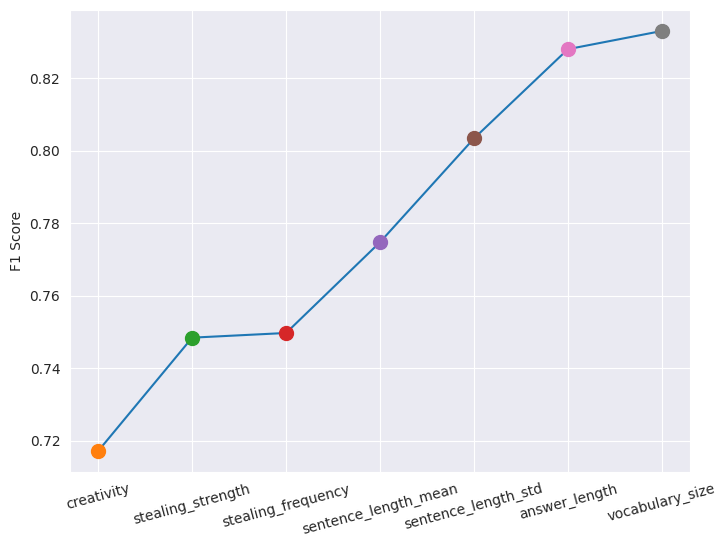

In [74]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))

sns.lineplot(x=all_features, y=scores)
plt.xticks(rotation=15)
for i in range(len(all_features)):
    plt.plot(all_features[i], scores[i], 'o', markersize=10)
plt.ylabel('F1 Score')
plt.savefig("features_input.png")

Conclusions:
* All features do add to the final score
* XGB shows significant improvement comparing to Logistic Regression

In [40]:
%%time
xgb_tuning_grid = {
    'n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int))),
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
}
grid_search_results = grid_search(xgb, xgb_tuning_grid, df_full_train[all_features], df_full_train.target)

Tuned Hyperparameters: {'learning_rate': 0.4, 'n_estimators': 20}
F1 score : 0.8366225725721967
CPU times: user 9min 13s, sys: 2.94 s, total: 9min 16s
Wall time: 1min 9s


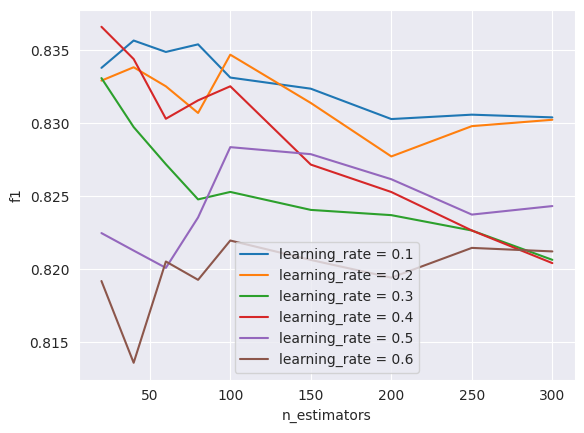

In [41]:
plot_grid_results(grid_search_results, x_var='n_estimators', legend_var='learning_rate')

In [77]:
%%time

xgb_tuning_grid = {
    'n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int))),
    'learning_rate': [0.1],
    'max_depth': [2, 3, 4, 5, 6, 7]
}
grid_search_results = grid_search(xgb, xgb_tuning_grid, df_full_train[all_features], df_full_train.target)

Tuned Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
F1 score : 0.8413954828574269
CPU times: user 15min 3s, sys: 5.2 s, total: 15min 8s
Wall time: 1min 54s


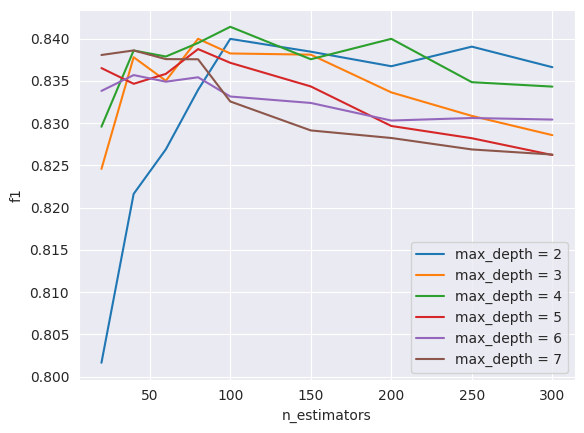

In [78]:
plot_grid_results(grid_search_results, x_var='n_estimators', legend_var='max_depth')

In [79]:
%%time

xgb_tuning_grid = {
    'n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int))),
    'learning_rate': [0.1],
    'max_depth': [4],
    'min_child_weight': [1, 2, 3, 4]
}
grid_search_results = grid_search(xgb, xgb_tuning_grid, df_full_train[all_features], df_full_train.target)

Tuned Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 60}
F1 score : 0.841711629509476
CPU times: user 10min 1s, sys: 4.75 s, total: 10min 6s
Wall time: 1min 16s


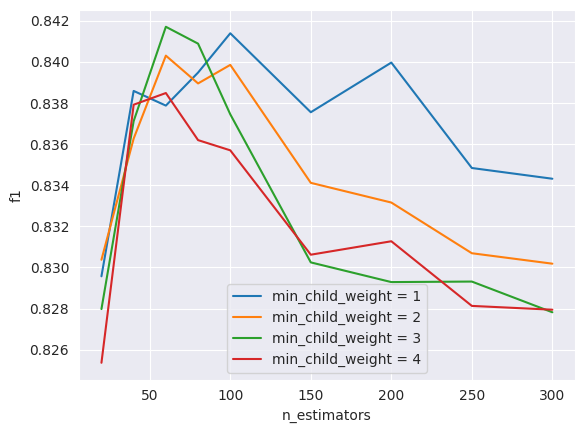

In [80]:
plot_grid_results(grid_search_results, x_var='n_estimators', legend_var='min_child_weight')

### Score on Test Data

In [137]:
xgb.set_params(**{'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 80})
xgb.fit(df_full_train[all_features], df_full_train.target)
xgb_score = round(f1_score(xgb.predict(df_test[all_features]), df_test.target), 3)
xgb_score

0.856

## Random Forest

In [82]:

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight="balanced")

all_features = ['creativity', 'stealing_strength', 'stealing_frequency', 'sentence_length_mean', 'sentence_length_std', 'answer_length', 'vocabulary_size']

features = []
scores = []
for f in all_features:
    features.append(f)
    score = cross_val_score(rfc, df_full_train[features], df_full_train.target, scoring='f1').mean()
    scores.append(score)
pd.DataFrame(list(zip(features, np.round(scores, 3))))

,0,1
0,creativity,0.630
1,stealing_strength,0.684
2,stealing_frequency,0.742
3,sentence_length_mean,0.777
4,sentence_length_std,0.807
5,answer_length,0.828
6,vocabulary_size,0.833


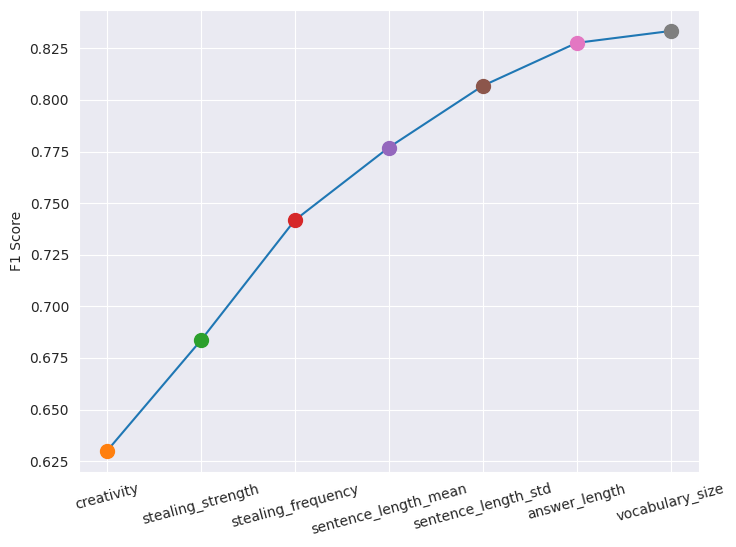

In [83]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))

sns.lineplot(x=all_features, y=scores)
plt.xticks(rotation=15)
for i in range(len(all_features)):
    plt.plot(all_features[i], scores[i], 'o', markersize=10)
plt.ylabel('F1 Score')
plt.savefig("features_input.png")

Conclusions:
* All features do add to the final score
* Random Forest shows significant improvement comparing to Logistic Regression

In [84]:
%%time
rfc_tuning_grid = {
    'max_depth': [50, 100, 200, 300, None],
    'n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int)))
}
grid_search_results = grid_search(rfc, rfc_tuning_grid, df_full_train[all_features], df_full_train.target)

Tuned Hyperparameters: {'max_depth': None, 'n_estimators': 300}
F1 score : 0.8390784017805524
CPU times: user 1min 35s, sys: 189 ms, total: 1min 35s
Wall time: 1min 35s


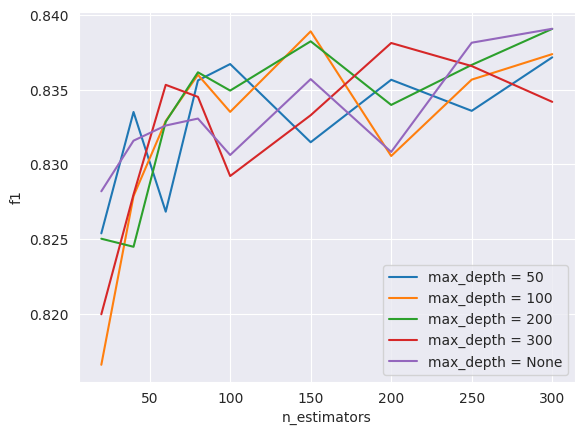

In [86]:
plot_grid_results(grid_search_results, x_var='n_estimators', legend_var='max_depth')

In [88]:
%%time

rfc_tuning_grid = {
    'max_depth': [100],
    'n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int))),
    'max_features': ['sqrt', None]
}
grid_search_results = grid_search(rfc, rfc_tuning_grid, df_full_train[all_features], df_full_train.target)

Tuned Hyperparameters: {'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 150}
F1 score : 0.8403709700561384
CPU times: user 56 s, sys: 109 ms, total: 56.1 s
Wall time: 56.1 s


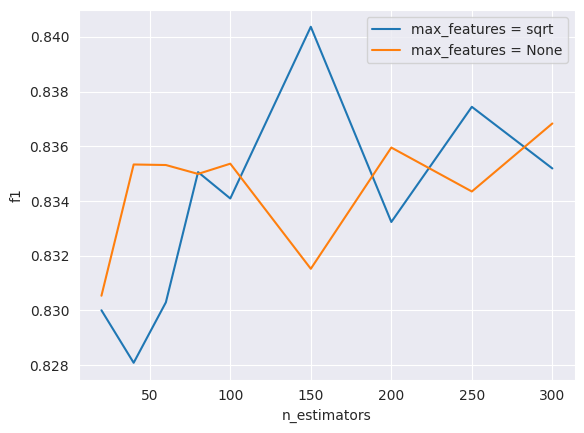

In [89]:
plot_grid_results(grid_search_results, x_var='n_estimators', legend_var='max_features')

In [90]:
%%time

rfc_tuning_grid = {
    'max_depth': [100],
    'n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int))),
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3, 4, 5],

}
grid_search_results = grid_search(rfc, rfc_tuning_grid, df_full_train[all_features], df_full_train.target)

Tuned Hyperparameters: {'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 250}
F1 score : 0.8422137130636476
CPU times: user 1min 27s, sys: 157 ms, total: 1min 27s
Wall time: 1min 27s


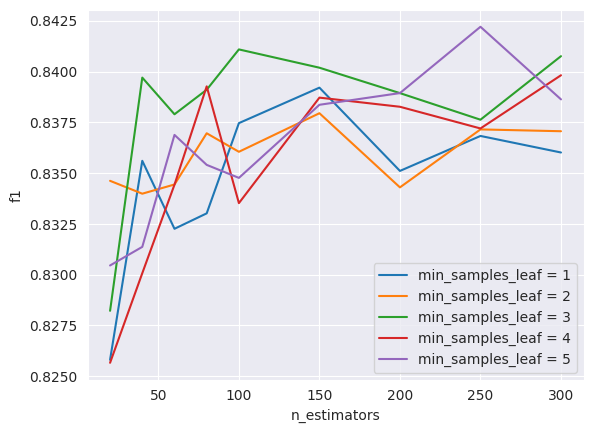

In [91]:
plot_grid_results(grid_search_results, x_var='n_estimators', legend_var='min_samples_leaf')

In [92]:
%%time

rfc_tuning_grid = {
    'max_depth': [100],
    'n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int))),
    'max_features': ['sqrt'],
    'min_samples_leaf': [5],
    'min_samples_split': [2, 10, 50, 100, 200]
}
grid_search_results = grid_search(rfc, rfc_tuning_grid, df_full_train[all_features], df_full_train.target)

Tuned Hyperparameters: {'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 150}
F1 score : 0.8419660872234322
CPU times: user 1min 14s, sys: 167 ms, total: 1min 14s
Wall time: 1min 14s


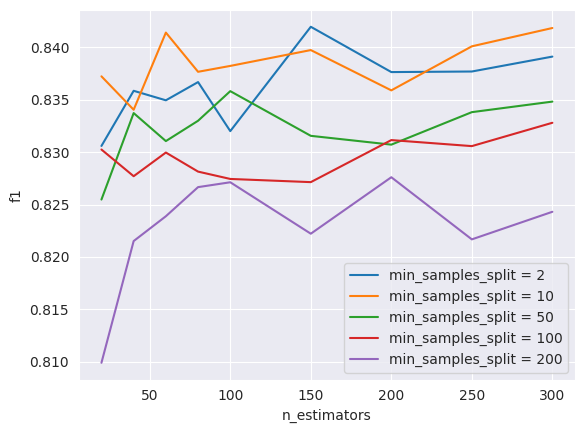

In [93]:
plot_grid_results(grid_search_results, x_var='n_estimators', legend_var='min_samples_split')

### Score on Test Data

In [145]:
rfc.set_params(**{'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 150})
rfc.fit(df_full_train[all_features], df_full_train.target)
rfc_score = round(f1_score(rfc.predict(df_test[all_features]), df_test.target), 3)
rfc_score

0.857

## Naive Bayes

In [95]:
count_vectorizer = CountVectorizer(min_df=10)
vectors = count_vectorizer.fit_transform(df_full_train.stemmed_answer)
vectors.shape

(2315, 1656)

In [96]:
nb = ComplementNB()
score = cross_val_score(nb, vectors, df_full_train.target, scoring='f1').mean()
score

0.8509936543459361

In [97]:
nb_tuning_grid = {
    'alpha': np.logspace(-3,2,6)
}

grid_search_results = grid_search(nb, nb_tuning_grid, vectors, df_full_train.target)

Tuned Hyperparameters: {'alpha': 1.0}
F1 score : 0.8509936543459361


In [98]:
%%time
nb_pipe_tuning_grid = {
    'nb_proba__alpha': [1.0],
    'c_vect__min_df': range(5, 10),
    'c_vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]
}

nb_pipe_classifier = Pipeline([('c_vect', CountVectorizer(min_df=10)),
                     ('nb_proba', ComplementNB())])

grid_search_results = grid_search(nb_pipe_classifier, nb_pipe_tuning_grid, df_full_train.stemmed_answer, df_full_train.target)

Tuned Hyperparameters: {'c_vect__min_df': 7, 'c_vect__ngram_range': (1, 4), 'nb_proba__alpha': 1.0}
F1 score : 0.9049342308123771
CPU times: user 54.9 s, sys: 1.37 s, total: 56.3 s
Wall time: 56.3 s


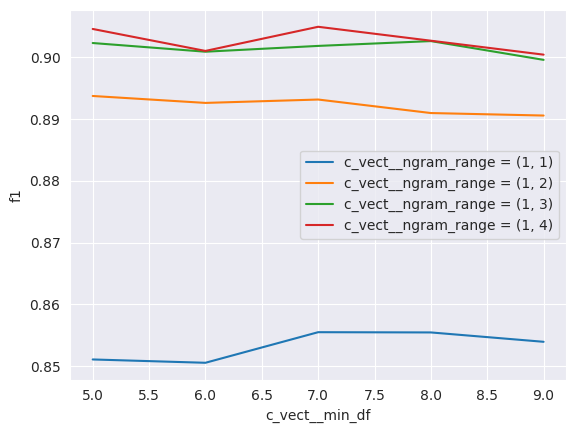

In [99]:
plot_grid_results(grid_search_results, x_var='c_vect__min_df', legend_var='c_vect__ngram_range')

### Score on Test Data

In [146]:
nb_pipe_classifier.set_params(**{'c_vect__min_df': 7, 'c_vect__ngram_range': (1, 4)})
nb_pipe_classifier.fit(df_full_train.stemmed_answer, df_full_train.target)
nb_score = round(f1_score(nb_pipe_classifier.predict(df_test.stemmed_answer), df_test.target), 3)
nb_score

0.911

## 2-Layered Pipeline
 Both Naive Bayes and XGBClassifier show good results. At the same time they use different aspects of data, so maybe it's possible to make them enhance each other.
So I plan to do the following:
1. Vectorize the `answer` column and train Naive Bayes on it
2. Apply Naive Bayes to the rows to predict probability `predict_proba()`.
3. Add this probability as another numerical feature to the data_frame
4. Combine this probability with `selected_features` and train XGBoostClassifier on the new set of numerical features

In [101]:
X_train = df_full_train[['stemmed_answer'] + all_features]
y_train = df_full_train.target
X_test = df_test[['stemmed_answer'] + all_features]
y_test = df_test.target

In order to do this trick, I need a custom transformer that wraps the Naive Bayes classifier and uses `predict_proba` in the `transform` method

In [102]:
class ComplementNBTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.clf = ComplementNB()

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self

    def transform(self, X):
        probas = self.clf.predict_proba(X)
        return pd.DataFrame(np.array([x[1] for x in probas]), columns=['nb_probability'])

Now I'm creating the pipeline that implements the plan:

In [147]:
nb_pipe = Pipeline([('c_vect', CountVectorizer(min_df=7, ngram_range=(1, 4))),
                     ('nb_proba', ComplementNBTransformer())])

columns = [('nb_pipe', nb_pipe, 'stemmed_answer')]

col_trans = ColumnTransformer(columns, remainder = 'passthrough') # the `remainder` part ensures that `all_features` are passed down the pipeline and later combined with the output of nb_pipe

full_pipe = Pipeline([('nb_col_trans', col_trans),
                     ('clf', xgb)])

cross_val_score(full_pipe, X_train, y_train, scoring='f1').mean()

0.9257908097938621

In [160]:
full_pipe.fit(X_train, y_train)
combined_score = f1_score(full_pipe.predict(X_test), y_test)
combined_score

0.9400000000000001

In [173]:
lr_name = 'Logistic Regression'
xgb_name = 'XGBoost'
rfc_name = 'Random Forest'
nb_name = 'Naive Bayes'
xgb_nb_name = 'XBGBoost + Naive Bayes'
df = pd.DataFrame({lr_name: [lr_score],
                   xgb_name: [xgb_score],
                   rfc_name: [rfc_score],
                   nb_name: [nb_score],
                   xgb_nb_name: [combined_score]})

feature_based_name = 'Feature based'
distribution_based_name = 'Distribution based'
combined_name = 'Combined pipeline'

# Create the MultiIndex with two levels of labels
superheader = 'Superheader'
columns = [(feature_based_name, lr_name),
           (feature_based_name, xgb_name),
           (feature_based_name, rfc_name),
           (distribution_based_name, nb_name),
           (combined_name, xgb_nb_name)]

df.columns = pd.MultiIndex.from_tuples(columns, names=['Approach', 'Models'])

# Show the dataframe with grouped columns
round(df, 3)

Approach       Feature based                       Distribution based  \
Models   Logistic Regression XGBoost Random Forest        Naive Bayes   
0                      0.805   0.856         0.857              0.911   

Approach      Combined pipeline  
Models   XBGBoost + Naive Bayes  
0                          0.94

In [105]:
%%time

xgb_tuning_grid = {
    'clf__n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int))),
    'clf__learning_rate': [0.1, 0.2, 0.3, 0.4],
}

xgb_tuning_results = grid_search(full_pipe, xgb_tuning_grid, X_train, y_train)

Tuned Hyperparameters: {'clf__learning_rate': 0.3, 'clf__n_estimators': 100}
F1 score : 0.9292208219128237
CPU times: user 10min 3s, sys: 5.21 s, total: 10min 9s
Wall time: 3min 44s


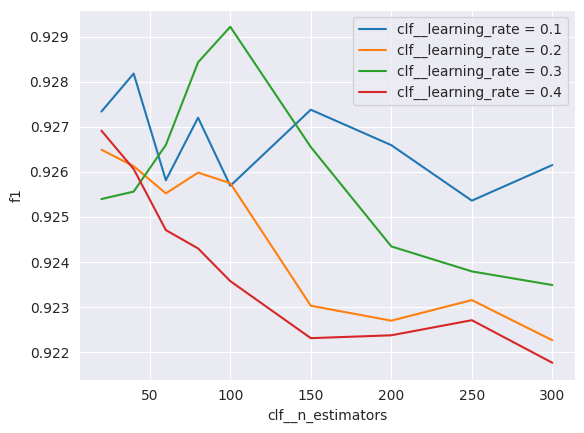

In [106]:
plot_grid_results(xgb_tuning_results, 'clf__n_estimators', legend_var='clf__learning_rate')

In [109]:
%%time

xgb_tuning_grid = {
    'clf__n_estimators': np.concatenate((np.linspace(70, 90, 6, dtype=int),
                                        np.linspace(140, 170, 7, dtype=int))),
    'clf__learning_rate': [0.3],
    'clf__max_depth': [3, 4, 5, 6]
}

xgb_tuning_results = grid_search(full_pipe, xgb_tuning_grid, X_train, y_train)

Tuned Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 82}
F1 score : 0.930098265281962
CPU times: user 15min 51s, sys: 6.28 s, total: 15min 57s
Wall time: 5min 34s


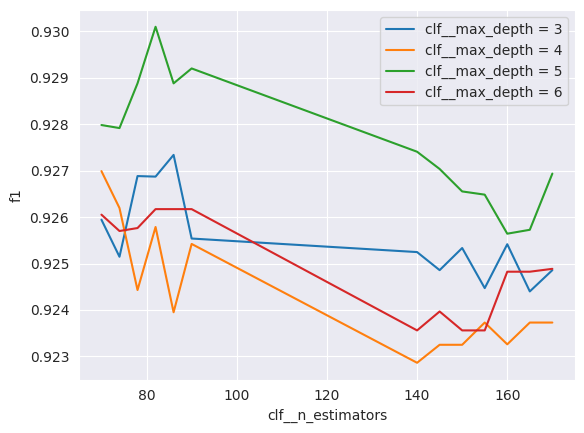

In [110]:
plot_grid_results(xgb_tuning_results, 'clf__n_estimators', legend_var='clf__max_depth')

In [111]:
%%time

xgb_tuning_grid = {
    'clf__n_estimators': np.linspace(70, 100, 7, dtype=int),
    'clf__learning_rate': [0.3],
    'clf__max_depth': [5],
    'clf__min_child_weight': [1, 2, 3, 4]
}

xgb_tuning_results = grid_search(full_pipe, xgb_tuning_grid, X_train, y_train)

Tuned Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__min_child_weight': 3, 'clf__n_estimators': 85}
F1 score : 0.9297648368705819
CPU times: user 6min 50s, sys: 3.13 s, total: 6min 53s
Wall time: 2min 43s


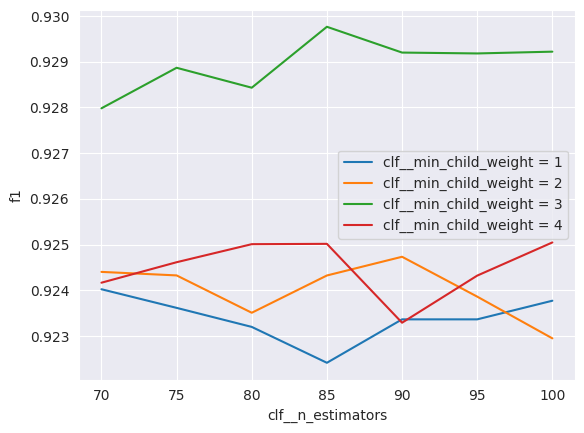

In [112]:
plot_grid_results(xgb_tuning_results, 'clf__n_estimators', legend_var='clf__min_child_weight')

## Trying on the test data

In [113]:
full_pipe.set_params(**{'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__min_child_weight': 3, 'clf__n_estimators': 85})
full_pipe.fit(X_train, y_train)

Pipeline(steps=[('nb_col_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nb_pipe',
                                                  Pipeline(steps=[('c_vect',
                                                                   CountVectorizer(min_df=5,
                                                                                   ngram_range=(1,
                                                                                                4))),
                                                                  ('nb_proba',
                                                                   ComplementNBTransformer())]),
                                                  'stemmed_answer')])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsampl...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               n_estimators=85, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [114]:
np.round(f1_score(full_pipe.predict(X_test), y_test), 3)

0.935

## Forest 2-layered

In [115]:
%%time

from sklearn.ensemble import RandomForestClassifier

nb_pipe = Pipeline([('c_vect', CountVectorizer(min_df=6, ngram_range=(1, 3))),
                     ('nb_proba', ComplementNBTransformer())])

columns = [('nb_pipe', nb_pipe, 'stemmed_answer')]

col_trans = ColumnTransformer(columns, remainder = 'passthrough') # the `remainder` part ensures that `selected_features` are passed down the pipeline and later combined with the output of nb_pipe

rf_pipe = Pipeline([('nb_col_trans', col_trans),
                     ('clf', RandomForestClassifier())])

cross_val_score(rf_pipe, X_train, y_train, scoring='f1').mean()

CPU times: user 6.61 s, sys: 19.8 ms, total: 6.63 s
Wall time: 6.63 s


0.9274288992411612

In [118]:
%%time

forest_tuning_grid =  {
    'clf__max_depth': [3, 5, 10, 20, 50, 100],
    'clf__n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int)))
}

forest_tuning_results = grid_search(rf_pipe, forest_tuning_grid, X_train, y_train)

Tuned Hyperparameters: {'clf__max_depth': 5, 'clf__n_estimators': 300}
F1 score : 0.9299076189035885
CPU times: user 4min 8s, sys: 344 ms, total: 4min 8s
Wall time: 4min 8s


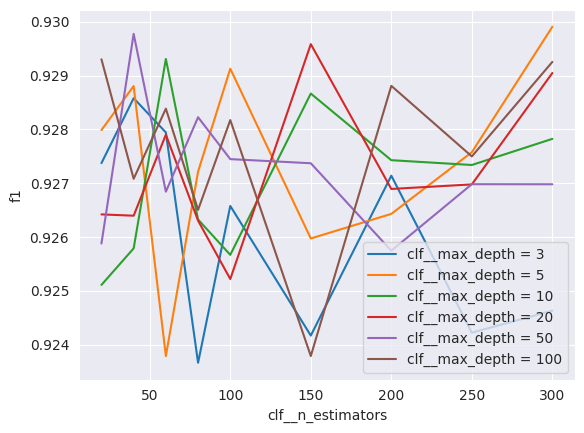

In [119]:
plot_grid_results(forest_tuning_results, 'clf__n_estimators', legend_var='clf__max_depth')

In [120]:
%%time

forest_tuning_grid =  {
    'clf__max_depth': [5],
    'clf__n_estimators': np.linspace(140, 300, 9, dtype=int),
    'clf__max_features': ['sqrt', None]
}

forest_tuning_results = grid_search(rf_pipe, forest_tuning_grid, X_train, y_train)

Tuned Hyperparameters: {'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__n_estimators': 240}
F1 score : 0.9282015710603192
CPU times: user 2min 1s, sys: 129 ms, total: 2min 1s
Wall time: 2min 1s


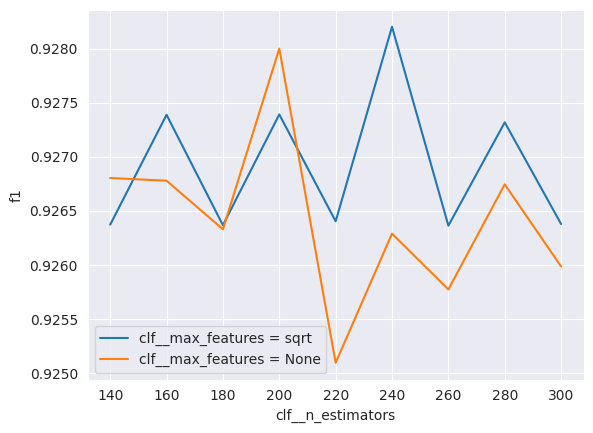

In [121]:
plot_grid_results(forest_tuning_results, 'clf__n_estimators', legend_var='clf__max_features')

In [122]:
%%time

forest_tuning_grid =  {
    'clf__max_depth': [5],
    'clf__n_estimators': np.linspace(140, 300, 9, dtype=int),
    'clf__max_features': ['sqrt'],
    'clf__min_samples_leaf': [1, 2, 3, 4, 5]
}

forest_tuning_results = grid_search(rf_pipe, forest_tuning_grid, X_train, y_train)

Tuned Hyperparameters: {'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 3, 'clf__n_estimators': 140}
F1 score : 0.9299120174750758
CPU times: user 4min 4s, sys: 225 ms, total: 4min 4s
Wall time: 4min 4s


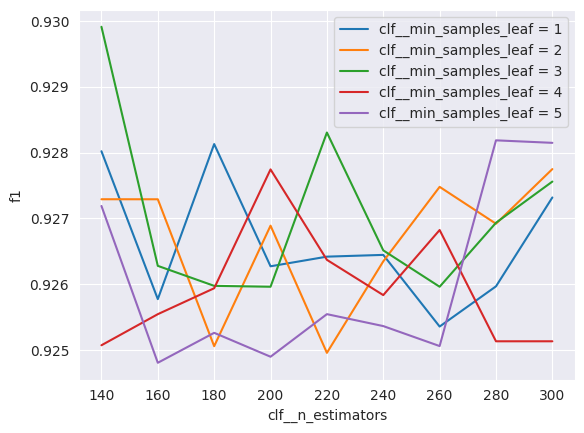

In [123]:
plot_grid_results(forest_tuning_results, 'clf__n_estimators', legend_var='clf__min_samples_leaf')

In [126]:
%%time

forest_tuning_grid =  {
    'clf__max_depth': [5],
    'clf__n_estimators': np.linspace(140, 300, 9, dtype=int),
    'clf__max_features': ['sqrt'],
    'clf__min_samples_leaf': [3],
    'clf__min_samples_split': [2, 10, 50, 100, 200]
}

forest_tuning_results = grid_search(rf_pipe, forest_tuning_grid, X_train, y_train)

Tuned Hyperparameters: {'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 140}
F1 score : 0.9281328336857969
CPU times: user 3min 40s, sys: 205 ms, total: 3min 40s
Wall time: 3min 40s


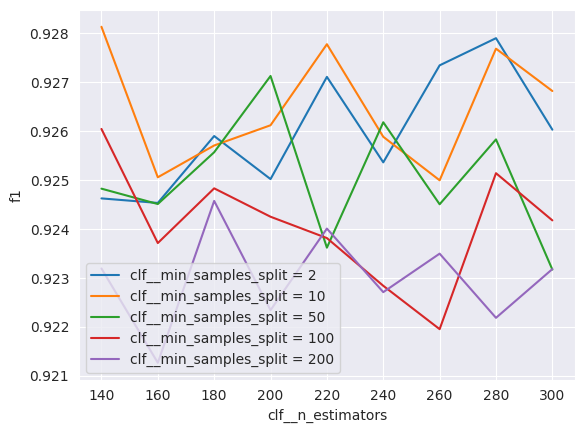

In [127]:
plot_grid_results(forest_tuning_results, 'clf__n_estimators', legend_var='clf__min_samples_split')

In [128]:
rf_pipe.set_params(**{'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 140})
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('nb_col_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nb_pipe',
                                                  Pipeline(steps=[('c_vect',
                                                                   CountVectorizer(min_df=6,
                                                                                   ngram_range=(1,
                                                                                                3))),
                                                                  ('nb_proba',
                                                                   ComplementNBTransformer())]),
                                                  'stemmed_answer')])),
                ('clf',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=3,
                                        min_samples_split=10,
                                        n_estimators=140))])

In [129]:
round(f1_score(y_test, rf_pipe.predict(X_test)), 3)

0.939